<a href="https://colab.research.google.com/github/Raghu290/AndriodAppQRScan/blob/master/credit_card_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(492, 29)


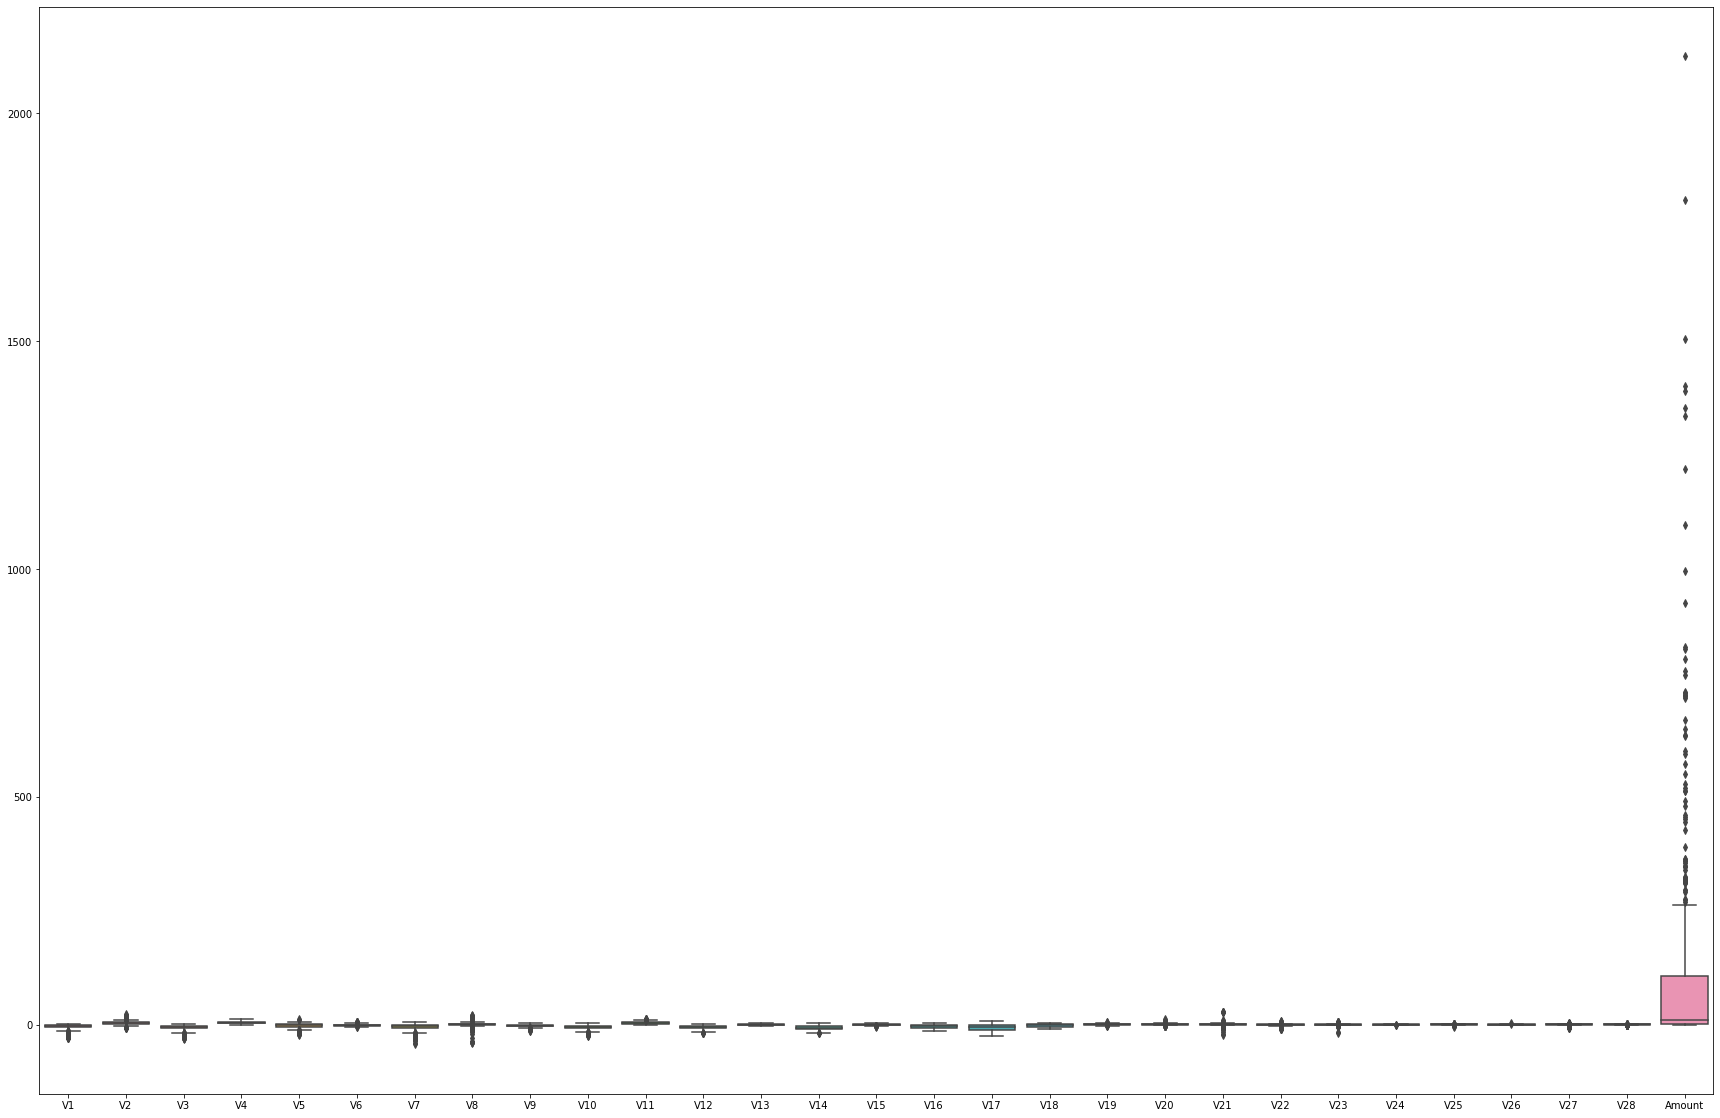

In [8]:
#Scaling 0-1 mandatory, feature noise vectore is selected 0-1
#CAnt discrimator be used of real transactions
#what metric should be used for evaluation of generator

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

credit_data = pd.read_csv("drive/MyDrive/creditcard.csv")
fraud_data = credit_data[credit_data['Class']==1]
fraud_data = fraud_data.drop('Time',axis=1)
fraud_data = fraud_data.drop('Class',axis=1)
fraud_data.to_csv("fraud_data.csv",index=False)
fraud_df = pd.read_csv("fraud_data.csv")
print(fraud_df.shape)
fig_dims = (30, 20)
fig, ax = plt.subplots(figsize=fig_dims)
fraud_ = fraud_df
sns.boxplot(ax=ax, data = fraud_) 

               V1            V2  ...         V28      Amount
count  492.000000  4.920000e+02  ...  492.000000  492.000000
mean    -0.432528  2.394666e-01  ...   -0.144232    1.076950
std      1.207736  1.134333e+00  ...    1.116876    2.447166
min     -5.022356 -2.939447e+00  ...   -4.113372   -0.088188
25%     -0.657585 -4.043431e-01  ...   -0.520820   -0.078654
50%      0.000000  5.870955e-17  ...    0.000000    0.000000
75%      0.342415  5.956569e-01  ...    0.479180    0.921346
max      0.796687  5.112265e+00  ...    3.332558   20.179426

[8 rows x 28 columns]


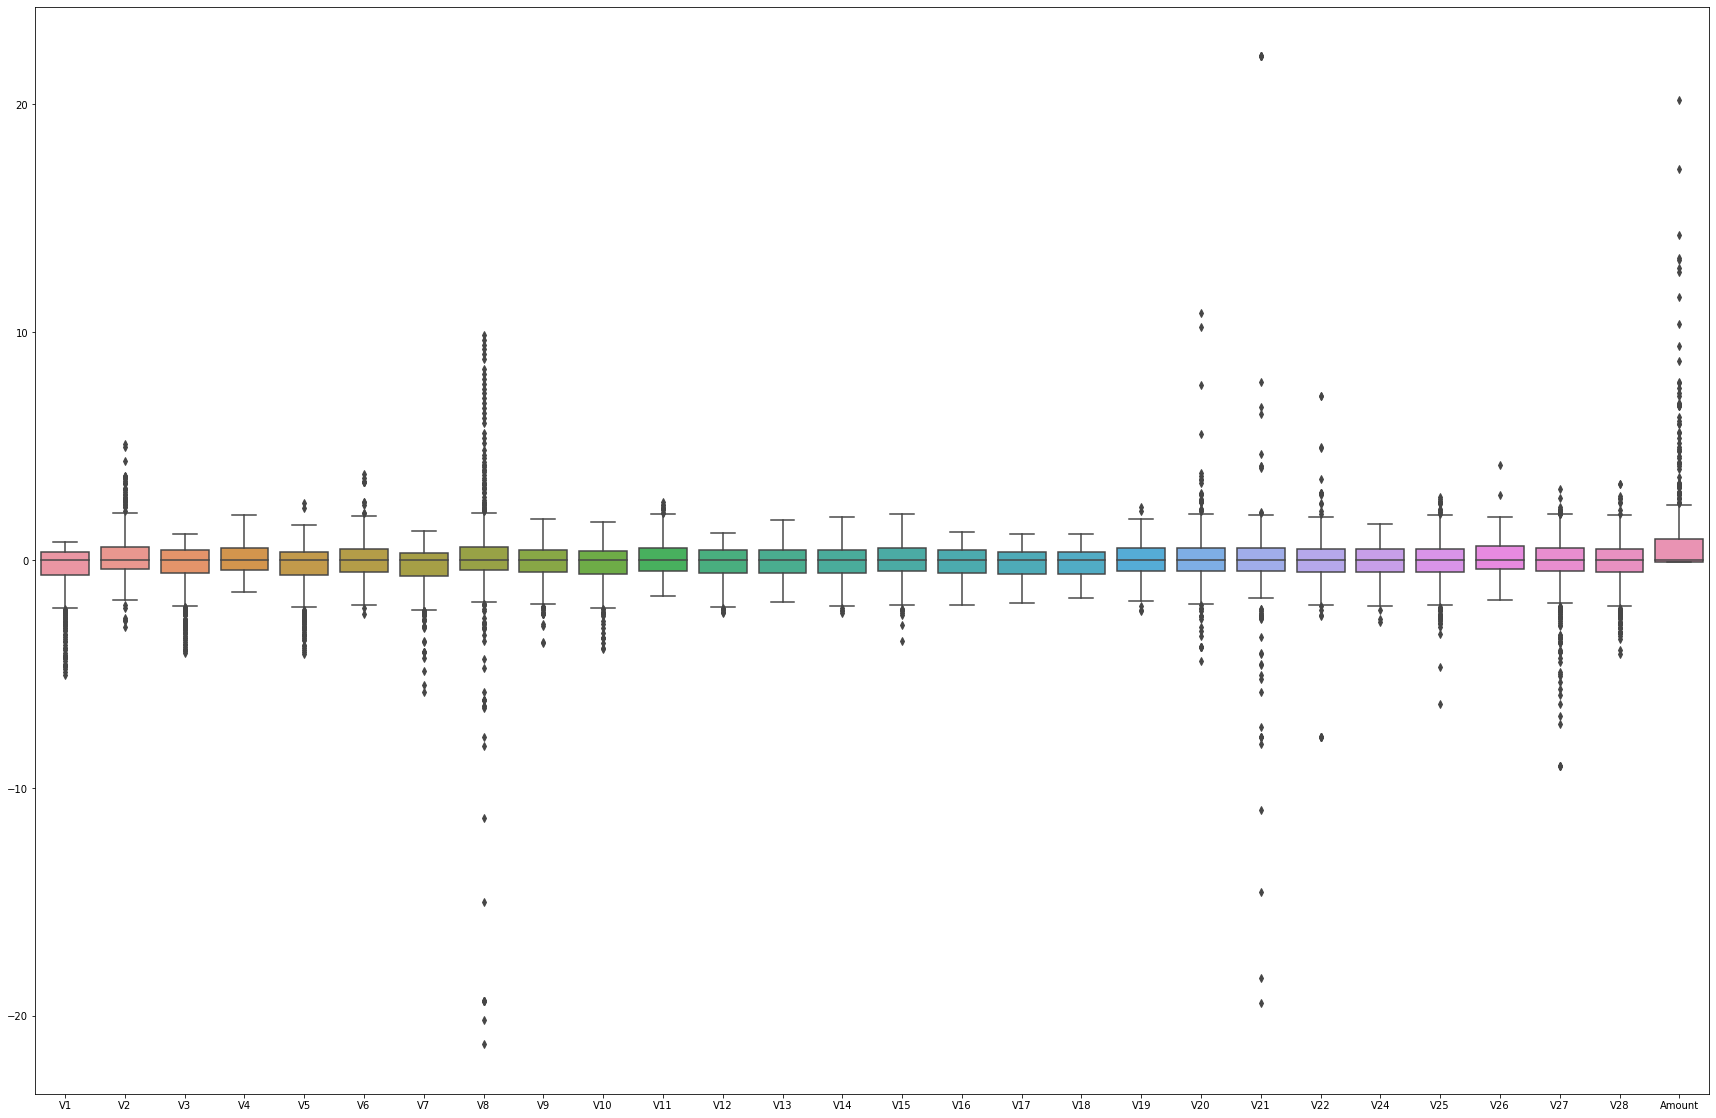

In [9]:
from sklearn.preprocessing import RobustScaler
fig_dims = (30, 20)
fraud_ = fraud_.drop('V23',axis=1)
fig, ax = plt.subplots(figsize=fig_dims)
fraud_df = pd.DataFrame(RobustScaler().fit_transform(fraud_), columns=fraud_.columns, index=fraud_.index)
sns.boxplot(ax=ax, data = fraud_df) 
fraud_df.to_csv("fraud_data.csv",index=False)
print(fraud_df.describe())

In [10]:
fraud_df = pd.read_csv("fraud_data.csv")
fraud_df = np.expand_dims(fraud_df,axis=1)
print(fraud_df.shape)

(492, 1, 28)


In [7]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf 
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn
from scipy.stats import pearsonr

print('Default GPU Device:{}'.format(tf.config.experimental.list_physical_devices('GPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#Define input image dimensions
#Large images take too much time and resources.
img_rows = 1
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

##########################################################################
#Given input of noise (latent) vector, the Generator produces an image.
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

#Define your generator network 
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.         

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)

#Alpha — α is a hyperparameter which controls the underlying value to which the
#function saturates negatives network inputs.
#Momentum — Speed up the training
##########################################################################

#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (we're calling it validity)

def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)
#The validity is the Discriminator’s guess of input being real or not.


#Now that we have constructed our two models it’s time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths. 
def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    #(X_train, _), (_, _) = mnist.load_data()
    X_train = fraud_df

    #print(X_train.shape)
    #print(X_train.shape[0])
    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    #X_train = (X_train.astype(np.float32) - 127.5) / 127.5

#Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3) 
    #print(X_train.shape)
    half_batch = int(batch_size / 2)


#We then loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true dataset, generating a set of images from our
#Generator, feeding both set of images into our Discriminator, and finally setting the
#loss parameters for both the real and fake images, as well as the combined loss. 
    
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        #print(imgs.shape)
 
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)
        #print("image shape")
        #print(gen_imgs.shape)
        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    #take average loss from real and fake images. 
    #
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
        
#And within the same loop we train our Generator, by setting the input noise and
#ultimately training the Generator to have the Discriminator label its samples as valid
#by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
#Create noise vectors as input for generator. 
#Create as many noise vectors as defined by the batch size. 
#Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


#Additionally, in order for us to keep track of our training process, we print the
#progress and save the sample image output depending on the epoch interval specified.  
# Plot the progress
        
        #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f , acc.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1]))
            save_imgs(epoch,imgs, half_batch)

#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def save_imgs(epoch, real_data,half_batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_data = generator.predict(noise)
    gen_data = np.squeeze(gen_data,axis=3)
    gen_data = np.squeeze(gen_data,axis=1)
    real_data = np.squeeze(real_data,axis=3)
    real_data = np.squeeze(real_data,axis=1)
    corr, _ = pearsonr(gen_data[:,3],real_data[:,3])
    print('Pearsons correlation for epoch {} : {}'.format( epoch, corr))
    
    
#This function saves our images for us to view


##############################################################################

#Let us also define our optimizer for easy use later on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, 
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(img)  #Validity check on the generated image


#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


train(epochs=10002, batch_size=100, save_interval=1000)

#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

generator.save('generator_model_credit_card.h5')  #Test the model on GAN4_predict...

                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample_image function.


Default GPU Device:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 28)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               14848     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total param